<a href="https://colab.research.google.com/github/bruAristimunha/miningAbandonment/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#bibliotecas empregadas nessa analise de dados
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import sklearn.preprocessing as sk # LabelEnconder

O presente conjunto de dados foi obtido conforme a [descrição](https://github.com/bruAristimunha/miningAbandonment) do projeto.


Apesar de o documento estar consistente. Há padrões de formatações indesejados para os algoritmos empregados nessa análise. Como, por exemplo, apenas informação sobre o **ID** em uma linha e as demais com valores faltantes, ou a falta de informação sobre os créditos das disciplinas.


Mesmo considerando que canal de obtenção de informação estar disponível, optamos pelo pre-processamento da informação levando em consideração o tempo de resposta.

In [38]:
link = "https://raw.githubusercontent.com/bruAristimunha/miningAbandonment/master/data/bcc.csv"
dados =  pd.read_csv(link,sep=";")
dados.head()

,ID DO ALUNO,ANO,QUADRIMESTRE,NOME_DISCIPLINA,COD_DISCIPLINA,CATEGORIA,A,B,C,D,F,O
0,1.0,2011.0,2º Quadrimestre,Bases Computacionais da Ciência,BIM0005-13,Obrigatória,NaN,NaN,NaN,1.0,NaN,NaN
1,NaN,NaN,NaN,Bases Matemáticas,BIN0003-13,Obrigatória,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,Iniciação à Pesquisa Científica I,ESZX129-13,Opção Limitada,1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Origem da Vida e Diversidade dos Seres Vivos,BIL0304-13,Obrigatória,NaN,1.0,NaN,NaN,NaN,NaN
4,NaN,NaN,3º Quadrimestre,Geometria Analítica,BCN0404-13,Obrigatória,NaN,NaN,NaN,NaN,1.0,NaN


Observamos dois padrões de preenchimento distintos ao que chamamos de identificação (aluno, ano, quadrimestre) e o conceitos obtidos. 

Para tanto, realizamos a separação dos dados e para o preenchimento dos valores faltantes de formas diferentes.

In [0]:
#Inicialmente separamos os conceitos dos alunos, removendo todos as informações
#que não estão relacionadas aos conceitos.
conceitos = dados.drop(['ID DO ALUNO', 'ANO', 
                        'QUADRIMESTRE', 'NOME_DISCIPLINA', 
                        'COD_DISCIPLINA', 'CATEGORIA'],axis=1).copy()

#Preenchemos os valores faltantes com valores 0.
conceitos = conceitos.fillna(0)

#repetimos o mesmo processo com complemento dos dados
identificacao = dados.drop(['A','B','C','D','F','O'],axis=1).copy()

#Sempre que há um valor faltante se preenche com o valor na linha superior 
#da mesma coluna
identificacao = identificacao.fillna(method='ffill')

In [0]:
#Juntamos esses dois conjuntos preenchidos com regras de negócio distantas na 
#variável tratada
tratado = pd.concat([identificacao,conceitos],axis=1)

#Ao lidar com string e por consequencia comparações entre, realizamos uma série 
#de padronizações visando tratar erros de grafia, ou variações por acentuação

#Remoção de acentos
tratado['NOME_DISCIPLINA'] = tratado['NOME_DISCIPLINA'].str.normalize('NFKD')

#Para minusculas
tratado['NOME_DISCIPLINA'] = tratado['NOME_DISCIPLINA'].str.lower()

#Encondificação para ASCII ignorando erros
tratado['NOME_DISCIPLINA'] = tratado['NOME_DISCIPLINA'].str.encode('ascii', errors='ignore')

#Decoficação para UTF-8, formato mais empregado nessa categoria de análise
tratado['NOME_DISCIPLINA'] = tratado['NOME_DISCIPLINA'].str.decode('utf-8')



In [41]:
#Resultado após o processo de preenchimento e padronização
tratado.head()

,ID DO ALUNO,ANO,QUADRIMESTRE,NOME_DISCIPLINA,COD_DISCIPLINA,CATEGORIA,A,B,C,D,F,O
0,1.0,2011.0,2º Quadrimestre,Bases Computacionais da Ciencia,BIM0005-13,Obrigatória,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,2011.0,2º Quadrimestre,Bases Matematicas,BIN0003-13,Obrigatória,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,2011.0,2º Quadrimestre,Iniciacao a Pesquisa Cientifica I,ESZX129-13,Opção Limitada,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2011.0,2º Quadrimestre,Origem da Vida e Diversidade dos Seres Vivos,BIL0304-13,Obrigatória,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,2011.0,3º Quadrimestre,Geometria Analitica,BCN0404-13,Obrigatória,0.0,0.0,0.0,0.0,1.0,0.0


## Seguindo, optamos nessa etapa pela criação das seguintes variáveis.



1.   Tempo na Universidade em Anos;
2.   Quantidade de créditos por quadrimestre;
3.   Diferença por quadrimestre da média de créditos global menos a quantidade no quadrimestre;
4.   z-score entre a quantidade créditos cursadas;
5.   Coeficiente de rendimento atual;
6.   Coeficiente de rendimento por quadrimestre;
7.   Porcentagem de reprovação na disciplina;
8.   Porcentagem de abadonos na disciplinas;
9. Distância entre o quadrimestre ideal e o quadrimestre cursado;


###   1. Tempo na Universidade em Anos

In [0]:
#Junção de ano + quadrimestre
tratado['ANO_QUAD']= tratado['ANO'].astype(str)+tratado['QUADRIMESTRE']

#Quadrimestre cursado obtido pelo groupby por ALUNO, aplicando no ANO_QUAD 
#uma codificação para label através da função do Sklearn, 
#além de aplicar a concatenação desses multiplos groupbys + 1 
tratado['QUAD_CURSADO'] = np.concatenate(tratado.groupby("ID DO ALUNO")['ANO_QUAD'].apply(sk.LabelEncoder().fit_transform).values) + 1

#Obteção dos anos na universidade dado a contagem de créditos.
tratado['ANOS_NA_UNIVER'] = tratado['QUAD_CURSADO']//3

In [160]:
tratado.head(5)

,ID DO ALUNO,ANO,QUADRIMESTRE,NOME_DISCIPLINA,COD_DISCIPLINA,CATEGORIA,A,B,C,D,F,O,ANO_QUAD,QUAD_CURSADO,ANOS_NA_UNIVER
0,1.0,2011.0,2º Quadrimestre,bases computacionais da ciencia,BIM0005-13,Obrigatória,0.0,0.0,0.0,1.0,0.0,0.0,2011.02º Quadrimestre,1,0
1,1.0,2011.0,2º Quadrimestre,bases matematicas,BIN0003-13,Obrigatória,0.0,0.0,0.0,0.0,1.0,0.0,2011.02º Quadrimestre,1,0
2,1.0,2011.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,0.0,0.0,0.0,0.0,2011.02º Quadrimestre,1,0
3,1.0,2011.0,2º Quadrimestre,origem da vida e diversidade dos seres vivos,BIL0304-13,Obrigatória,0.0,1.0,0.0,0.0,0.0,0.0,2011.02º Quadrimestre,1,0
4,1.0,2011.0,3º Quadrimestre,geometria analitica,BCN0404-13,Obrigatória,0.0,0.0,0.0,0.0,1.0,0.0,2011.03º Quadrimestre,2,0


## 2. Quantidade de créditos por quadrimestre;

Para essa análise necessitamos da quantidade créditos teóricos, práticos e individuais de cada disciplinas. Para tanto, buscamos o [catálogo de disciplinas](prograd.ufabc.edu.br/pdf/catalogo_disciplinas_grad>uacao_2017_2018_v2.xlsx) da universidade. Removemos as informações sobre as ementas desse arquivo anteriormente.

In [161]:
catalogo = 'https://raw.githubusercontent.com/bruAristimunha/miningAbandonment/master/data/catalogo_disciplinas_graduacao_2017_2018.csv'
disciplinas = pd.read_csv(catalogo, sep="|")
disciplinas.head()

,SIGLA,DISCIPLINA,T,P,I,RECOMENDAÇÃO
0,ESHR022-14,Abordagens Tradicionais das Relações Internaci...,4,0,4,Não há
1,ESZM035-17,Aditivação de Polímeros,4,0,4,Síntese de Polímeros; Materiais Poliméricos
2,ESZP041-14,Administração Pública e Reforma do Estado em P...,4,0,4,Não há
3,ESTS016-17,Aerodinâmica I,4,0,5,Dinâmica de Gases
4,ESZS019-17,Aerodinâmica II,4,0,5,Aerodinâmica I


Realizamos um pré-processamento das *strings* desse novo conjunto.

In [0]:
#Remoção de acentos
disciplinas['DISCIPLINA'] = disciplinas['DISCIPLINA'].str.normalize('NFKD')

#Para minusculas
disciplinas['DISCIPLINA'] = disciplinas['DISCIPLINA'].str.lower()

#Encondificação para ASCII ignorando erros
disciplinas['DISCIPLINA'] = disciplinas['DISCIPLINA'].str.encode('ascii', errors='ignore')

#Decoficação para UTF-8, formato mais empregado nessa categoria de análise
disciplinas['DISCIPLINA'] = disciplinas['DISCIPLINA'].str.decode('utf-8')

Antes disso, realizamos uma análise das disciplinas listadas verificando se não há disciplinas com 
nomes replicados.

In [163]:
abs(len(disciplinas['DISCIPLINA'].unique()) - len(disciplinas['DISCIPLINA']))

2

Há duas disciplinas com nomes replicados, sendo esses:

In [164]:
disciplinas[disciplinas['DISCIPLINA'].duplicated()]

,SIGLA,DISCIPLINA,T,P,I,RECOMENDAÇÃO
162,ESZG023-17,contabilidade para engenharia,4,0,5,Economia de Empresas
467,ESHT009-17,historia da cidade e do urbanismo,4,0,4,Não há


Talvez seja interessante reportar à universidade. Seguindo nossa análise, verificamos que há 139 disciplinas que estão nos históricos dos alunos, mas não estão no catálogo de disciplina. Isso ocorre, pois, as disciplinas foram substituidas por outras.

In [165]:
disci_fora_catalogo = tratado['NOME_DISCIPLINA'].unique()[~np.isin(tratado['NOME_DISCIPLINA'].unique(),disciplinas['DISCIPLINA'].unique())]
len(disci_fora_catalogo)

139

Analisando o conjunto de disciplinas elencadas observamos que essas disciplinas são datadas dos primeiros projetos pedagógicos da universidade.

Dessa forma, recorremos ao primeiro catálogo de disciplinas (2011) e analisamos se haverá redução do número de disciplinas sem informações sobre T-P-I.



In [167]:
catalogo2011 = "https://raw.githubusercontent.com/bruAristimunha/miningAbandonment/master/data/catalogo_de_disciplinas_2011.csv"

disciplinas2011 = pd.read_csv(catalogo2011, sep="|")
disciplinas2011.columns = ['SIGLA', 'DISCIPLINA', 'T', 'P', 'I']

#Remoção de acentos
disciplinas2011['DISCIPLINA'] = disciplinas2011['DISCIPLINA'].str.normalize('NFKD')

#Para minusculas
disciplinas2011['DISCIPLINA'] = disciplinas2011['DISCIPLINA'].str.lower()

#Encondificação para ASCII ignorando erros
disciplinas2011['DISCIPLINA'] = disciplinas2011['DISCIPLINA'].str.encode('ascii', errors='ignore')

#Decoficação para UTF-8, formato mais empregado nessa categoria de análise
disciplinas2011['DISCIPLINA'] = disciplinas2011['DISCIPLINACreated using Colaboratory'].str.decode('utf-8')


disciplinas2011.columns

Index(['SIGLA', 'DISCIPLINA', 'T', 'P', 'I'], dtype='object')

In [168]:
disciplinas = disciplinas.append(disciplinas2011, sort=True)


disciplinas =  disciplinas[['SIGLA', 'DISCIPLINA', 'T', 'P', 'I', 'RECOMENDAÇÃO']]
disciplinas.head()

,SIGLA,DISCIPLINA,T,P,I,RECOMENDAÇÃO
0,ESHR022-14,abordagens tradicionais das relacoes internaci...,4,0,4,Não há
1,ESZM035-17,aditivacao de polimeros,4,0,4,Síntese de Polímeros; Materiais Poliméricos
2,ESZP041-14,administracao publica e reforma do estado em p...,4,0,4,Não há
3,ESTS016-17,aerodinamica i,4,0,5,Dinâmica de Gases
4,ESZS019-17,aerodinamica ii,4,0,5,Aerodinâmica I


Com essa abordagem reduzimos para 18 o número de disciplinas com informações faltantes

In [169]:
foraCatalogo = tratado['NOME_DISCIPLINA'].unique()[~np.isin(tratado['NOME_DISCIPLINA'].unique(),disciplinas['DISCIPLINA'].unique())]
print(len(foraCatalogo))

2


Optamos pelo preenchimento manual e adição ao catalogo mais antigo (2011).

In [170]:
foraCatalogo

array(['projeto de aeronavesi', 'combustao'], dtype=object)

Essa disciplinas não foram encontradas em nenhum fonte oficial de informação. 
Prosseguindo temos então:


In [0]:
tratado.columns = ['ID DO ALUNO', 'ANO', 'QUADRIMESTRE', 'DISCIPLINA',
       'COD_DISCIPLINA', 'CATEGORIA', 'A', 'B', 'C', 'D', 'F', 'O', 'ANO_QUAD',
       'QUAD_CURSADO', 'ANOS_NA_UNIVER']

In [238]:
tratado.head()

,ID DO ALUNO,ANO,QUADRIMESTRE,DISCIPLINA,COD_DISCIPLINA,CATEGORIA,A,B,C,D,F,O,ANO_QUAD,QUAD_CURSADO,ANOS_NA_UNIVER
0,1.0,2011.0,2º Quadrimestre,bases computacionais da ciencia,BIM0005-13,Obrigatória,0.0,0.0,0.0,1.0,0.0,0.0,2011.02º Quadrimestre,1,0
1,1.0,2011.0,2º Quadrimestre,bases matematicas,BIN0003-13,Obrigatória,0.0,0.0,0.0,0.0,1.0,0.0,2011.02º Quadrimestre,1,0
2,1.0,2011.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,0.0,0.0,0.0,0.0,2011.02º Quadrimestre,1,0
3,1.0,2011.0,2º Quadrimestre,origem da vida e diversidade dos seres vivos,BIL0304-13,Obrigatória,0.0,1.0,0.0,0.0,0.0,0.0,2011.02º Quadrimestre,1,0
4,1.0,2011.0,3º Quadrimestre,geometria analitica,BCN0404-13,Obrigatória,0.0,0.0,0.0,0.0,1.0,0.0,2011.03º Quadrimestre,2,0


In [0]:
tratado_01 = tratado.copy()
disciplinas_unique = disciplinas.drop_duplicates('DISCIPLINA')
tratado_02 = tratado_01.merge(disciplinas_unique,on='DISCIPLINA').sort_values(['ID DO ALUNO','ANO'])

In [0]:
tratado_02['CRED'] = tratado_02['T'] + tratado_02['P']

In [0]:
creditos_por_quad = tratado_02.groupby(['ID DO ALUNO', 'ANO', 'QUADRIMESTRE'])['CRED'].apply(sum)

In [304]:
tratado_02.groupby(['ID DO ALUNO', 'ANO', 'QUADRIMESTRE'])['T','P'].apply(list)

ID DO ALUNO  ANO     QUADRIMESTRE   
1.0          2011.0  2º Quadrimestre    [T, P]
                     3º Quadrimestre    [T, P]
             2012.0  1º Quadrimestre    [T, P]
                     2º Quadrimestre    [T, P]
                     3º Quadrimestre    [T, P]
             2013.0  1º Quadrimestre    [T, P]
                     2º Quadrimestre    [T, P]
                     3º Quadrimestre    [T, P]
             2015.0  3º Quadrimestre    [T, P]
             2016.0  1º Quadrimestre    [T, P]
                     2º Quadrimestre    [T, P]
                     3º Quadrimestre    [T, P]
             2017.0  1º Quadrimestre    [T, P]
                     2º Quadrimestre    [T, P]
                     3º Quadrimestre    [T, P]
2.0          2013.0  1º Quadrimestre    [T, P]
                     2º Quadrimestre    [T, P]
                     3º Quadrimestre    [T, P]
             2014.0  1º Quadrimestre    [T, P]
                     2º Quadrimestre    [T, P]
                     3º

In [230]:
np.mean(tratado_01.groupby(["ID DO ALUNO","ANO","QUADRIMESTRE"])['CRED'].apply(np.sum))

4.7486910994764395

In [228]:
for a in tratado_01.groupby(["ID DO ALUNO","ANO","QUADRIMESTRE"])['DISCIPLINA','CRED']:
  print(a[1])

    ID DO ALUNO     ANO     QUADRIMESTRE  \
0           1.0  2011.0  2º Quadrimestre   
13          1.0  2011.0  2º Quadrimestre   

                                      DISCIPLINA COD_DISCIPLINA  \
0              iniciacao a pesquisa cientifica i     ESZX129-13   
13  origem da vida e diversidade dos seres vivos     BIL0304-13   

         CATEGORIA    A    B    C    D  ...    O               ANO_QUAD  \
0   Opção Limitada  1.0  0.0  0.0  0.0  ...  0.0  2011.02º Quadrimestre   
13     Obrigatória  0.0  1.0  0.0  0.0  ...  0.0  2011.02º Quadrimestre   

   QUAD_CURSADO  ANOS_NA_UNIVER   SIGLA  T  P  I  RECOMENDAÇÃO CRED  
0             1               0  BC2001  2  0  3           NaN    2  
13            1               0  BC0304  3  0  4           NaN    3  

[2 rows x 21 columns]
     ID DO ALUNO     ANO     QUADRIMESTRE  \
134          1.0  2011.0  3º Quadrimestre   

                                    DISCIPLINA COD_DISCIPLINA    CATEGORIA  \
134  transformacoes nos seres vivos e

In [220]:
tratado_01

,ID DO ALUNO,ANO,QUADRIMESTRE,DISCIPLINA,COD_DISCIPLINA,CATEGORIA,A,B,C,D,F,O,ANO_QUAD,QUAD_CURSADO,ANOS_NA_UNIVER,SIGLA,T,P,I,RECOMENDAÇÃO
0,1.0,2011.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,2,0.0,0.0,0.0,2011.02º Quadrimestre,1,0,BC2001,2,0,3,NaN
1,2.0,2013.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,2,0.0,0.0,0.0,2013.02º Quadrimestre,2,0,BC2001,2,0,3,NaN
2,35.0,2012.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,2,0.0,0.0,0.0,2012.02º Quadrimestre,1,0,BC2001,2,0,3,NaN
3,70.0,2013.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,0.0,0.0,2,1.0,0.0,0.0,2013.02º Quadrimestre,17,5,BC2001,2,0,3,NaN
4,131.0,2013.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,2,0.0,0.0,0.0,2013.02º Quadrimestre,7,2,BC2001,2,0,3,NaN
5,144.0,2013.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,0.0,1.0,2,0.0,0.0,0.0,2013.02º Quadrimestre,10,3,BC2001,2,0,3,NaN
6,146.0,2013.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,2,0.0,0.0,0.0,2013.02º Quadrimestre,7,2,BC2001,2,0,3,NaN
7,157.0,2010.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,0.0,0.0,2,0.0,0.0,0.0,2010.02º Quadrimestre,1,0,BC2001,2,0,3,NaN
8,164.0,2013.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,2,0.0,0.0,0.0,2013.02º Quadrimestre,7,2,BC2001,2,0,3,NaN
9,173.0,2013.0,2º Quadrimestre,iniciacao a pesquisa cientifica i,ESZX129-13,Opção Limitada,1.0,0.0,2,0.0,0.0,0.0,2013.02º Quadrimestre,17,5,BC2001,2,0,3,NaN


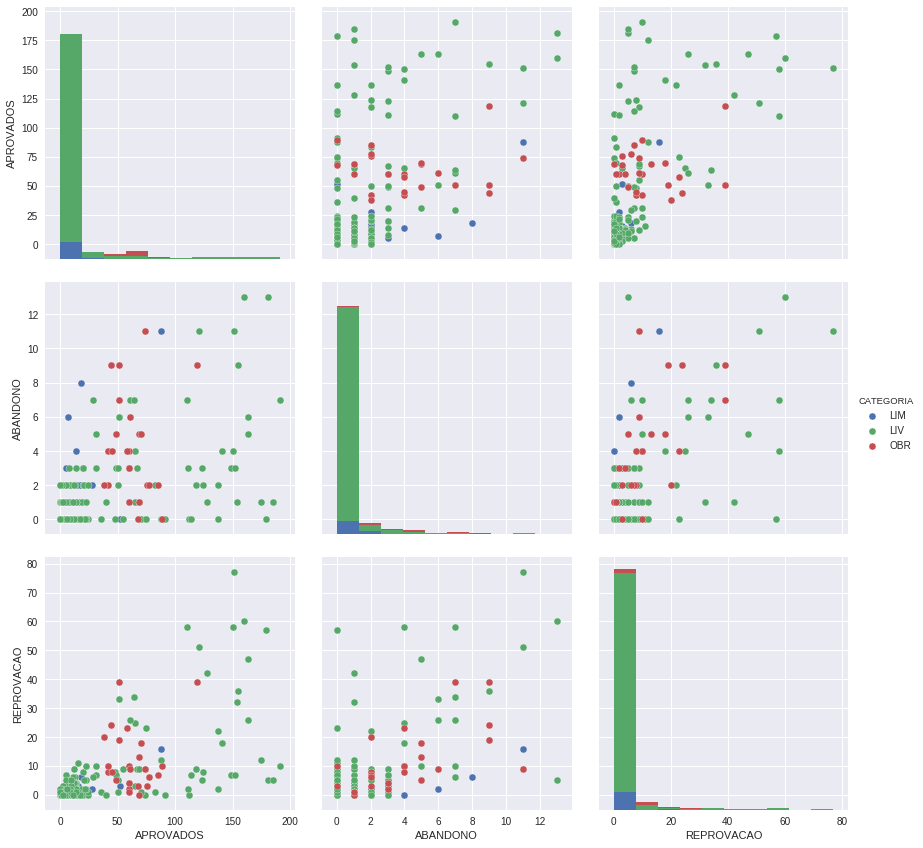

In [0]:

b.sort_values('APROVADOS',ascending=False )


sns.pairplot(b, hue="CATEGORIA",size=4)

In [0]:
b = b.drop("LIMITADAS",1)
b = b.drop("OBRIGATORIAS",1)

In [0]:
b['CATEGORIA'] = b['CATEGORIA'].astype('category')

In [0]:
#files.upload()

disc_01 = pd.read_csv("obrigatoriasBCC.csv")

len(disc_01)

26

In [0]:
disc_01.head()

,Sigla,Nome,T,P,I,Créditos,Tipo
0,MCTA009-13,Computadores Ética e Sociedade,2.0,0.0,4.0,2,OBCC
1,MCTB001-17,Álgebra Linear,6.0,0.0,5.0,6,OBCC
2,MCTA001-17,Algoritmos e Estruturas de Dados I,2.0,2.0,4.0,4,OBCC
3,MCTA003-17,Análise de Algoritmos,4.0,0.0,4.0,4,OBCC
4,MCTA006-17,Circuitos Digitais,3.0,1.0,4.0,4,OBCC


In [0]:
files.upload()

disc = pd.read_csv("limitadasBCC.csv")
len(disc)

Saving limitadasBCC.csv to limitadasBCC.csv


70

In [0]:
disc.columns = ['CODIGO','NOME','T','P','I','CRED','CAT']

In [0]:
disc['NOME'] = disc['NOME'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [0]:
b = b.reset_index()

In [0]:
disciplinas = b[b['NOME_DISCIPLINA'].isin(disc['NOME'])]

In [0]:
disciplinas = disciplinas.reset_index().drop('index',axis=1).sort_values('APROVADOS',ascending=False )

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


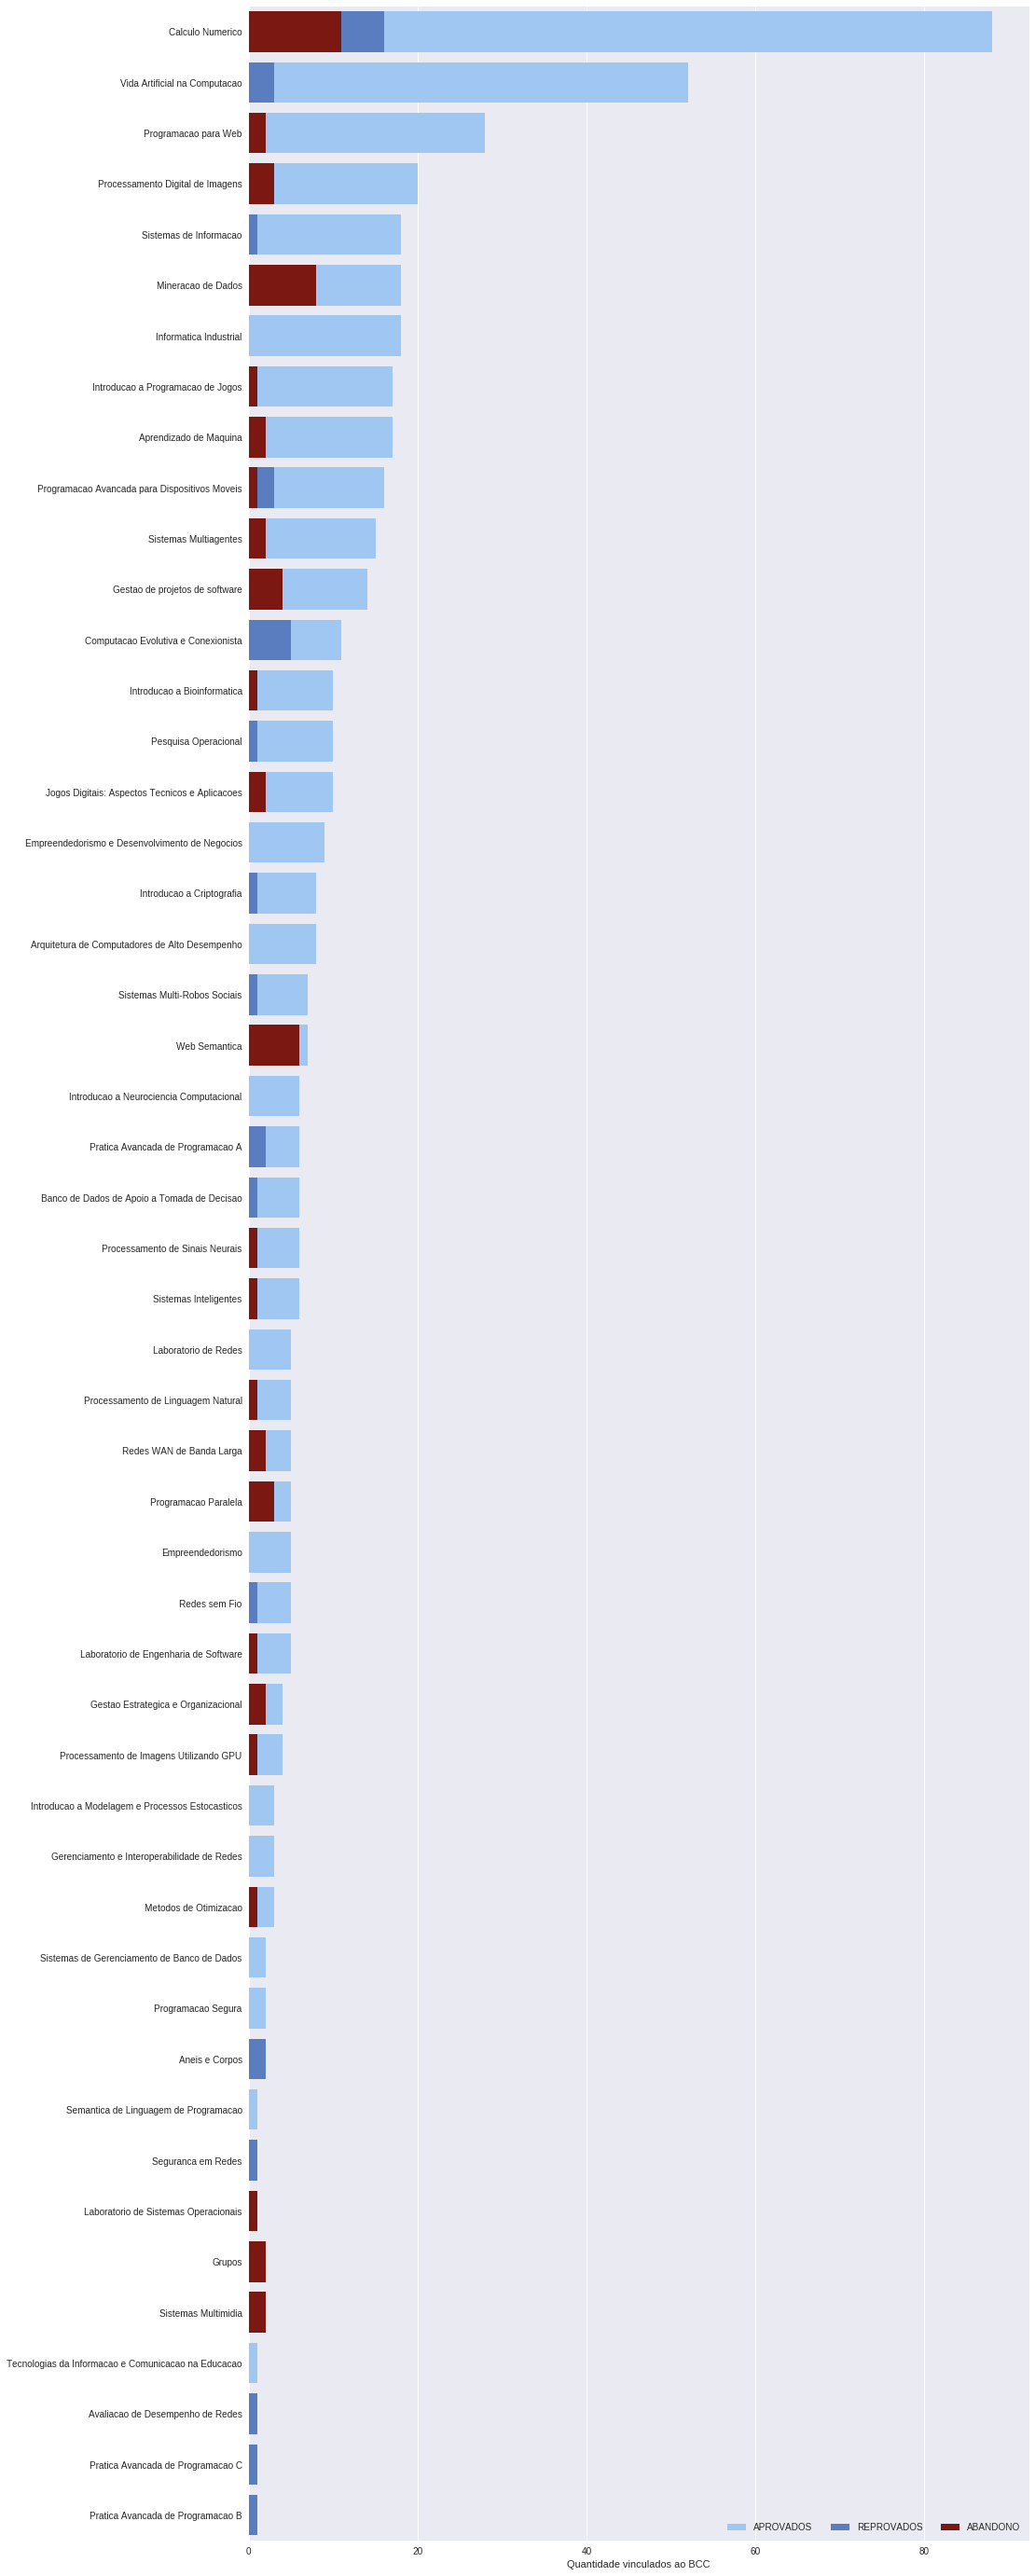

In [0]:
f, ax = plt.subplots(figsize=(15,50))

sns.set_color_codes("pastel")
sns.barplot(x="APROVADOS", y="NOME_DISCIPLINA", data=disciplinas,
            label="APROVADOS", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="REPROVACAO", y="NOME_DISCIPLINA", data=disciplinas,
            label="REPROVADOS", color="b")

sns.set_color_codes("dark")
sns.barplot(x="ABANDONO", y="NOME_DISCIPLINA", data=disciplinas,
            label="ABANDONO", color="r")


ax.legend(ncol=3, loc="lower right")
ax.set(ylabel="", xlabel="Quantidade vinculados ao BCC")
sns.despine(left=True, bottom=True)
